Notebook with the design of the Core Simulation class, Conventional radio and Cognitive Radio v1

In [190]:
class Simulation:    
    import numpy as np
    import pandas as pd     
    import seaborn as sns
    
    def __init__(self,channels=10,granularity=1,cycles=720):        
        self.channels = channels
        self.granularity = granularity
        self.cycles = cycles
        self.radios = []
        self.sfdf = pd.DataFrame(np.zeros((cycles, channels)))            
        
    def addRadio(self,radio, channel):
        self.radios.append(radio)
        self.sfdf[channel] = radio.generate()
        
    def addCognitiveRadio(self,radio):
        self.radios.append(radio)
        
    def run(self):
        print "Begin Simulation"
        print "Network :"
        for ra in self.radios:
            print ra.describe()
            
        
        total_clashes = self.sfdf[self.sfdf > 1].count().sum()
        total_blocks = self.sfdf.count().sum()
        Confidence = 1 - float(total_clashes)/total_blocks
        
        print "Network Confidence : " + str(Confidence*100) +"%"
        
        used_blocks = self.sfdf[self.sfdf > 0].count().sum()
        Eficiency = float(used_blocks)/total_blocks
        
        print "Spectrum Eficieny : " + str(Eficiency*100) +"%"
        
        self.plot()
        
    def plot(self):
        print "Method to plot and present results"
        
        ax = sns.heatmap(test.sfdf, vmax=self.sfdf.max().max())
        
        
    
        

In [191]:
class ConventionalRadio:
    
    import numpy as np
    def __init__(self,period,cycles,channel):
        self.period = period
        self.cycles = cycles
        self.channel = channel
        
    def generate(self):
        tmp_period= abs(self.period)
        usage = np.ones(self.cycles, dtype = 'float')
        on_period= np.ones(tmp_period)
        off_period = np.zeros(tmp_period)
        true_usage = np.tile(np.concatenate((on_period, off_period), axis=0),int(self.cycles/(2*tmp_period)))
        true_usage = true_usage if self.period>0 else usage
        return true_usage
    def describe(self):
        return "Conventional Radio with Period " + str(self.period) + " located in channel " + str(self.channel)
        

Begin Simulation
Network :
Conventional Radio with Period 1 located in channel 1
Conventional Radio with Period -1 located in channel 2
Conventional Radio with Period 4 located in channel 3
Conventional Radio with Period 2 located in channel 4
Conventional Radio with Period 6 located in channel 5
Conventional Radio with Period 12 located in channel 6
Conventional Radio with Period 1 located in channel 7
Conventional Radio with Period 4 located in channel 8
Conventional Radio with Period -1 located in channel 9
Conventional Radio with Period 4 located in channel 0
Network Confidence : 100.0%
Spectrum Eficieny : 60.0%
Method to plot and present results


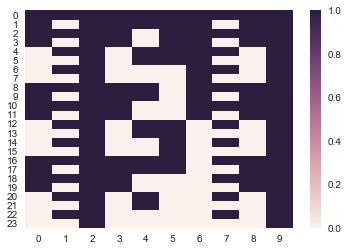

In [193]:
import numpy as np
import pandas as pd  
import seaborn as sns
%matplotlib inline

test = Simulation(cycles=24)
radio1= ConventionalRadio(1,24,1)
test.addRadio(radio1,1)
radio2= ConventionalRadio(-1,24,2)
test.addRadio(radio2,2)
radio3= ConventionalRadio(4,24,3)
test.addRadio(radio3,3)
radio4= ConventionalRadio(2,24,4)
test.addRadio(radio4,4)
radio5= ConventionalRadio(6,24,5)
test.addRadio(radio5,5)
radio6= ConventionalRadio(12,24,6)
test.addRadio(radio6,6)
radio7= ConventionalRadio(1,24,7)
test.addRadio(radio7,7)
radio8= ConventionalRadio(4,24,8)
test.addRadio(radio8,8)
radio9= ConventionalRadio(-1,24,9)
test.addRadio(radio9,9)
radio0= ConventionalRadio(4,24,0)
test.addRadio(radio0,0)
test.run()

In [169]:
test.sfdf

,0,1,2,3,4,5,6,7,8,9
0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
test.sfdf.plot

TypeError: scatter() takes at least 3 arguments (1 given)

In [129]:
test.sfdf[test.sfdf > 1].count().sum()

1440L

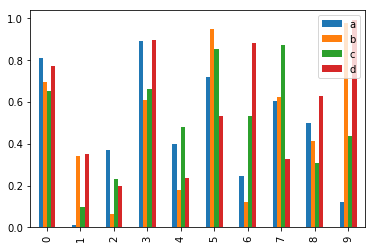

In [173]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

df2.plot.bar();

In [177]:
import seaborn as sns

In [185]:
test.sfdf.max().max()

1.0

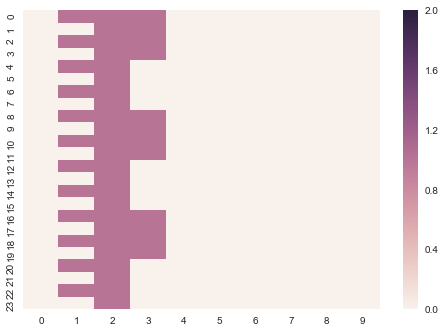

In [183]:
uniform_data = np.random.rand(10, 12)


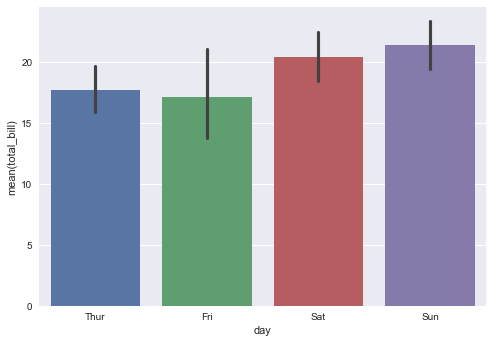